<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px">1. INTRODUCTION</div>

This notebooks is to apply AutoEncoderDecoder in solving Dimensionality Reduction

 ## <font color=red>**Stacked AutoEncoder**</font>
 
 ###  <font color=blue>Introduction</font>
 
1.	An auto-encoder is a kind of intersection between supervised and unsupervised learning that is commonly used for dimensionality reduction and feature discovery. More precisely, an auto-encoder is a feedforward neural network that is trained to predict the input itself. 


2. To prevent the system from learning the trivial identity mapping, the hidden layer in the middle is usually constrained to be a narrow bottleneck. The system can minimize the reconstruction error by ensuring the hidden units capture the most relevant aspects of the data which can be considered as the lower representation of data

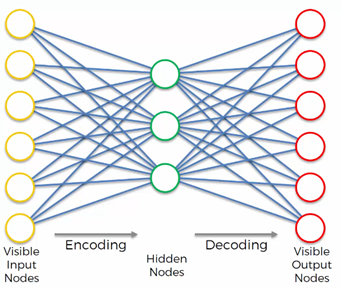


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em;  font-size: 25px">2. SETUP</div>

 # <font color=red>2.1. Import library</font>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
import sklearn.decomposition as dec
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# Common imports
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import os


## for processing text data
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem import SnowballStemmer
from nltk.tokenize.toktok import ToktokTokenizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import string
import re
from bs4 import BeautifulSoup
import unicodedata
from nltk.corpus import stopwords

# for calculating similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import  LabelEncoder

# for classification
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

## for word embedding
import gensim
import gensim.downloader as gensim_api
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

# to make this notebook's output stable across runs
np.random.seed(42)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
# import seaborn to make nice plots
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

C:\Users\Mai\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


 # <font color=red>2.2. Utitlity functions</font>

In [2]:
def plot_cluster(X, y):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    ax[0].scatter(X[:,0], X[:,1], s=5)
    ax[1].scatter(X[:,0], X[:,1], c=y, s=5, cmap='jet')
    plt.axis("off")
    plt.show()
    
    
def plot_data(X, y, n_cluster):
    palette = np.array(sns.color_palette("hls", n_cluster))

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    sc = ax.scatter(X[:,0], X[:,1], s=3,c=y, cmap="jet")
    # We add the labels for each digit.
    txts = []
    for i in range(n_cluster):
        # Position of each label.
        xtext, ytext = np.median(X[y == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
                PathEffects.Stroke(linewidth=3, foreground="w"),
                PathEffects.Normal()])
        txts.append(txt)    
        
        
def compare_truelabel_cluster(X, y, cluster):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    ax[0].scatter(X[:,0], X[:,1], s=3, c=y, cmap='jet')
    ax[1].scatter(X[:,0], X[:,1], s=3, c=cluster, cmap='jet')
    plt.axis('off')
    plt.show()
    
    
def show_image(images, n_images=5):
    nrows, ncols = 1, 5
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    plt.gray()
    for i in range(ncols * nrows):
        ax = plt.subplot(nrows, ncols, i + 1)
        ax.imshow(images.reshape(len(images),28,28)[i])
        plt.xticks([])
        plt.yticks([])    
            
    plt.show()    

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px">3. IMAGE DATA - MNISTS DATASET</div>

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set

the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

 # <font color=red>3.1. Data Preparation</font>

 ### <font color=blue>**Full dataset**

In [8]:
fashion_mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

print(X_train_full.dtype)
print(X_train_full.shape, X_test.shape)

uint8
(60000, 28, 28) (10000, 28, 28)


 ### <font color=blue>**User a part of full dataset to reduce the training time**

In [9]:
X_valid, X_train = X_train_full[:5000], X_train_full[45000:]
y_valid, y_train = y_train_full[:5000], y_train_full[45000:]
X_test = X_test
X_train.shape, X_valid.shape, X_test.shape

((15000, 28, 28), (5000, 28, 28), (10000, 28, 28))

In [10]:
from sklearn.preprocessing import MinMaxScaler

X_train_full = X_train_full.reshape(-1,784)
X_test = X_test.reshape(-1,784)

scaler = MinMaxScaler()
X_train_full = scaler.fit_transform(X_train_full.astype(np.float32))
X_test = scaler.transform(X_test.astype(np.float32))
#X_train_full = X_train_full.astype(np.float32) / 255
#X_test = X_test.astype(np.float32) / 255

X_train_full.shape, X_test.shape

((60000, 784), (10000, 784))

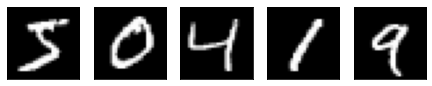

In [11]:
show_image(X_train_full[0:5], 5)

 ### <font color=blue>**User a part of full dataset to reduce the training time**

In [12]:
X_valid, X_train = X_train_full[:5000], X_train_full[45000:]
y_valid, y_train = y_train_full[:5000], y_train_full[45000:]
X_test = X_test
X_train.shape, X_valid.shape, X_test.shape

((15000, 784), (5000, 784), (10000, 784))

In [13]:
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train.shape, X_valid.shape, X_test.shape

((55000, 784), (5000, 784), (10000, 784))

 # <font color=red>3.2. AutoEncoder</font>

 ### <font color=blue>**Import libraries**

In [14]:
# Deep Learnign libraries
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from IPython.display import display, Math, Latex
import datetime

 ### <font color=blue>**Construct Model**

In [15]:
tf.random.set_seed(42)
np.random.seed(42)
keras.backend.clear_session()
tf.keras.backend.clear_session()

# No of Neurons in each layer []
input_dim = X_train.shape[1]
encoding1_dim = 100
encoding2_dim = 500
latent_dim = 20

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(encoding1_dim), activation="relu")(input_layer)
encoder = Dense(int(encoding2_dim), activation='relu')(encoder)
encoder = Dense(int(latent_dim), activation='relu')(encoder)
decoder = Dense(int(encoding2_dim), activation='relu')(encoder)
decoder = Dense(int(encoding1_dim), activation='relu')(decoder)
decoder = Dense(int(input_dim), activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 500)               50500     
                                                                 
 dense_2 (Dense)             (None, 20)                10020     
                                                                 
 dense_3 (Dense)             (None, 500)               10500     
                                                                 
 dense_4 (Dense)             (None, 100)               50100     
                                                                 
 dense_5 (Dense)             (None, 784)               79184 

In [16]:
tf.random.set_seed(42)
np.random.seed(42)
keras.backend.clear_session()
tf.keras.backend.clear_session()

# No of Neurons in each layer []
input_dim = X_train.shape[1]
encoding1_dim = 350
encoding2_dim = 150
latent_dim = 20

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(encoding1_dim), activation="relu")(input_layer)
encoder = Dense(int(encoding2_dim), activation='relu')(encoder)
encoder = Dense(int(latent_dim), activation='relu')(encoder)
decoder = Dense(int(encoding2_dim), activation='relu')(encoder)
decoder = Dense(int(encoding1_dim), activation='relu')(decoder)
decoder = Dense(int(input_dim), activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 350)               274750    
                                                                 
 dense_1 (Dense)             (None, 150)               52650     
                                                                 
 dense_2 (Dense)             (None, 20)                3020      
                                                                 
 dense_3 (Dense)             (None, 150)               3150      
                                                                 
 dense_4 (Dense)             (None, 350)               52850     
                                                                 
 dense_5 (Dense)             (None, 784)               275184

In [17]:
# this models maps an input to its encoded representation
encoder_layer = Model(input_layer, encoder)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(int(latent_dim),))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-3]
# create the decoder model
decoder_layer = Model(encoded_input, decoder_layer(encoded_input))

decoder_layer

 ### <font color=blue>**Training model**

In [18]:
nb_epoch = 20
batch_size = 10
autoencoder.compile(optimizer='adam', loss='mse')

cp = ModelCheckpoint(filepath='autoencoder1.h5', save_best_only=True, verbose=0)
tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
t_ini = datetime.datetime.now()
history = autoencoder.fit(X_train, 
                          X_train, 
                          epochs=nb_epoch, 
                          #batch_size=batch_size, 
                          shuffle=True, 
                          validation_data=(X_valid, X_valid),
                          #verbose=1,
).history
t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))

df_history = pd.DataFrame(history)

Epoch 1/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0258 - val_loss: 0.0194
Epoch 2/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0183 - val_loss: 0.0174
Epoch 3/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0167 - val_loss: 0.0163
Epoch 4/20
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0156 - val_loss: 0.0154
Epoch 5/20
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0148 - val_loss: 0.0147
Epoch 6/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 7/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 8/20
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0137 - val_loss: 0.0138
Epoch 9/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0134 - val_loss: 0.0136
Epoch 10/20
1719/1719 [==============================] - 16s 9ms/step -

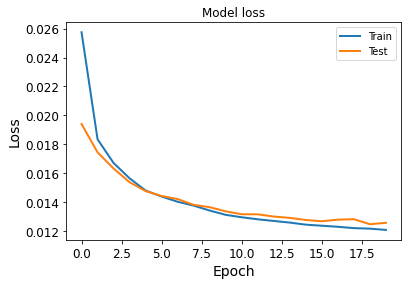

In [19]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

 ### <font color=blue>**Visualize Result**

In [20]:
np.random.seed(42)

from sklearn.manifold import TSNE
tsne = TSNE()
X_valid_ae = encoder_layer.predict(X_valid)
X_valid_ae_tsne = tsne.fit_transform(X_valid_ae)

tsne = TSNE()
X_valid_tsne = tsne.fit_transform(X_valid)

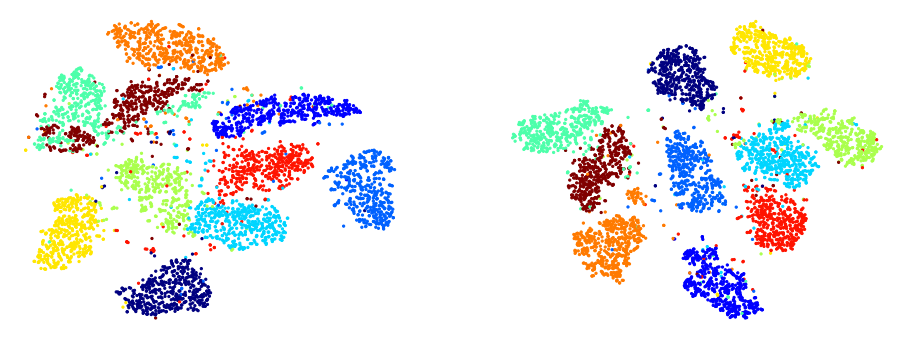

In [21]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_valid_tsne[:, 0], X_valid_tsne[:, 1], c=y_valid, s=5, cmap="jet")
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_valid_ae_tsne[:, 0], X_valid_ae_tsne[:, 1], c=y_valid, s=5, cmap="jet")
plt.axis("off")
plt.show()

 ### <font color=blue>**Apply Clustering to embedded features**

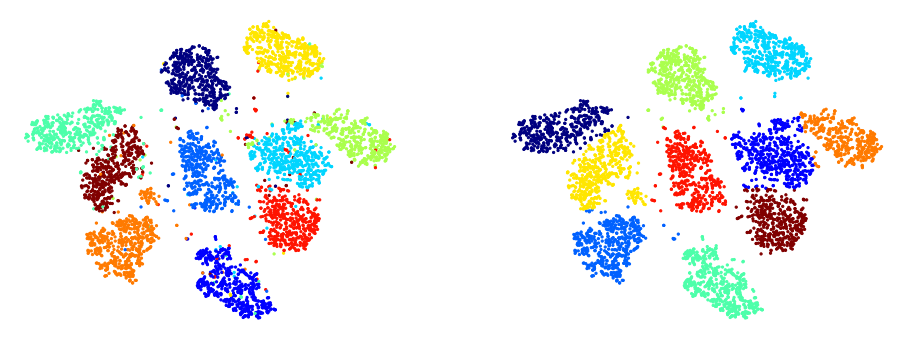

In [22]:
cluster_df = pd.DataFrame(y_valid, columns=['Label'])
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=9)
kmeans.fit(X_valid_ae_tsne)
cluster_labels = kmeans.labels_
cluster_df['KMeans_cluster'] = cluster_labels

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_valid_ae_tsne[:, 0], X_valid_ae_tsne[:, 1], c=cluster_df ['Label'], s=5, cmap="jet")
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_valid_ae_tsne[:, 0], X_valid_ae_tsne[:, 1], c=cluster_df ['KMeans_cluster'], s=5, cmap="jet")
plt.axis("off")
plt.show()

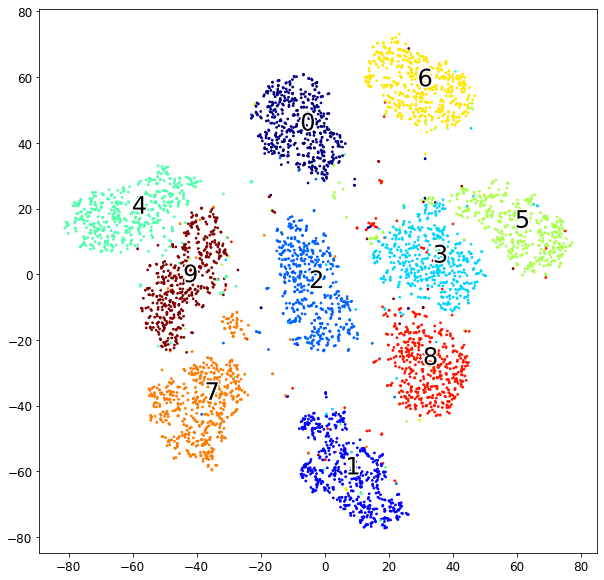

In [23]:
plot_data(X_valid_ae_tsne, y_valid, 10)

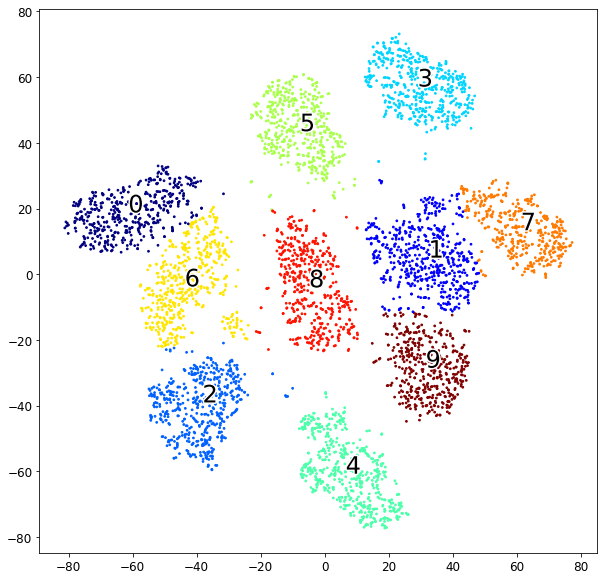

In [24]:
plot_data(X_valid_ae_tsne, cluster_df ['KMeans_cluster'], 10)

 # <font color=red>3.3. Variational AutoEncoder</font>

 ### <font color=blue>**Cost function**

In [25]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))
        
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

 ### <font color=blue>**Train model**

In [26]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 20

inputs = keras.layers.Input(shape=[784])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(300, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(300, activation="selu")(x)
x = keras.layers.Dense(784, activation="selu")(x)
outputs = keras.layers.Reshape([784])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="mse", optimizer="adam")
history = variational_ae.fit(X_train, X_train, epochs=20, #batch_size=5000,
                             validation_data=(X_valid, X_valid))
df_history = pd.DataFrame(history.history)

Epoch 1/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0562 - val_loss: 0.0512
Epoch 2/20
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0501 - val_loss: 0.0486
Epoch 3/20
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0482 - val_loss: 0.0474
Epoch 4/20
1719/1719 [==============================] - 16s 10ms/step - loss: 0.0473 - val_loss: 0.0466
Epoch 5/20
1719/1719 [==============================] - 13s 7ms/step - loss: 0.0466 - val_loss: 0.0462
Epoch 6/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0462 - val_loss: 0.0458
Epoch 7/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0459 - val_loss: 0.0454
Epoch 8/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0457 - val_loss: 0.0451
Epoch 9/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0454 - val_loss: 0.0448
Epoch 10/20
1719/1719 [==============================] - 12s 7ms/step 

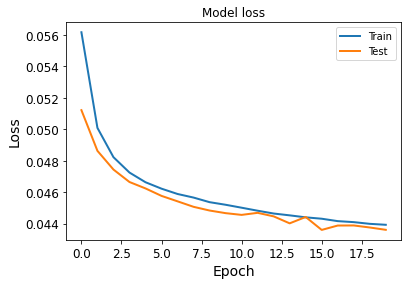

In [27]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

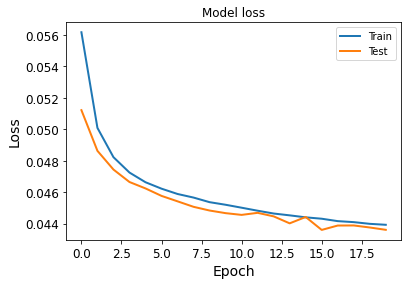

In [28]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [29]:
np.random.seed(42)

from sklearn.manifold import TSNE
tsne = TSNE()
X_valid_vae = variational_encoder.predict(X_valid)[0]
X_valid_vae_tsne = tsne.fit_transform(X_valid_vae)

tsne = TSNE()
#X_valid_tsne = tsne.fit_transform(X_valid)

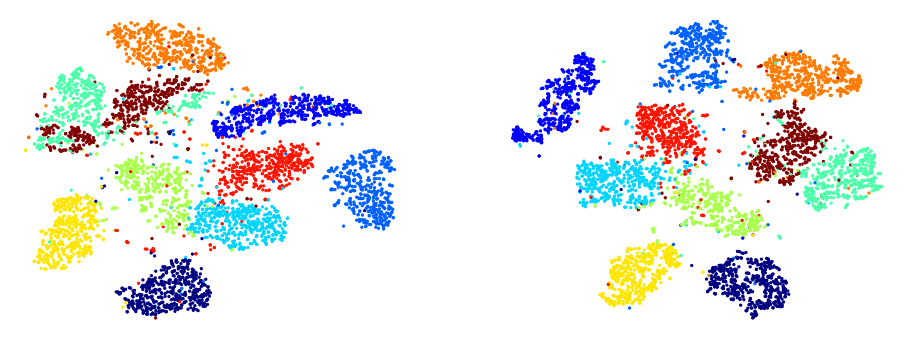

In [30]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_valid_tsne[:, 0], X_valid_tsne[:, 1], c=y_valid, s=5, cmap="jet")
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_valid_vae_tsne[:, 0], X_valid_vae_tsne[:, 1], c=y_valid, s=5, cmap="jet")
plt.axis("off")
plt.show()

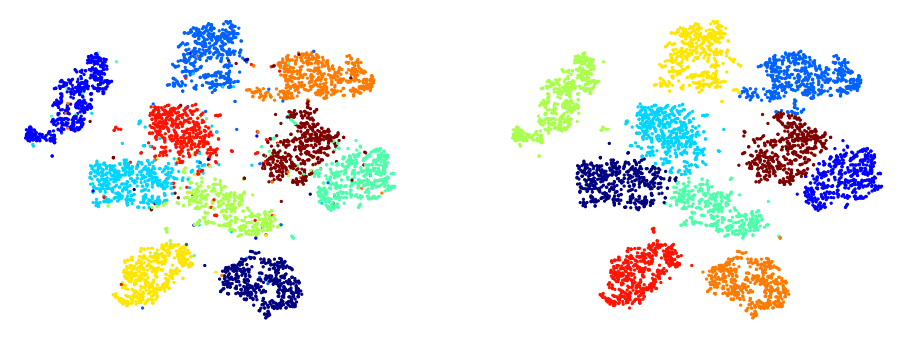

In [31]:
cluster_df = pd.DataFrame(y_valid, columns=['Label'])
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=9)
kmeans.fit(X_valid_vae_tsne)
cluster_labels = kmeans.labels_
cluster_df['KMeans_cluster'] = cluster_labels

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_valid_vae_tsne[:, 0], X_valid_vae_tsne[:, 1], c=cluster_df ['Label'], s=5, cmap="jet")
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_valid_vae_tsne[:, 0], X_valid_vae_tsne[:, 1], c=cluster_df ['KMeans_cluster'], s=5, cmap="jet")
plt.axis("off")
plt.show()

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px">4. TEXT DATA - NEWS CATEGORY</div>

The dataset used is “News category dataset” from Kaggle (https://www.kaggle.com/rmisra/news-category-dataset). This dataset is around 200k news headlines from the year 2012 to 2018 obtained from HuffPost. The original dataset contains over 30 categories, but for the purposes of this analysis, I will work with a subset of 4: TRAVEL, FOOD & DRINK, BUSINESS, SPORTS

 
 The following steps are applied for converting text data to numeric features:
 
 + Detect language and filter only English
 + Normalize text
 + Split data into train set and test set
 + Feature Extraction using word embedding with Word2Vec model
 + Scaling independent features
 + Convert target from categorical data to numeric data

 # <font color=red>4.1. Data Preparation</font>

### <font color=blue>Import data</font>

In [32]:
df = pd.read_csv('data/News_Category.csv')
print(df.shape)
## print 5 random rows
df = df.reset_index(drop=True)
df.head(5)

(26768, 4)


,category,headline,short_description,text
0,BUSINESS,"U.S. Launches Auto Import Probe, China Vows To...",The investigation could lead to new U.S. tarif...,"U.S. Launches Auto Import Probe, China Vows To..."
1,BUSINESS,Starbucks Says Anyone Can Now Sit In Its Cafes...,The new policy was unveiled weeks after the co...,Starbucks Says Anyone Can Now Sit In Its Cafes...
2,BUSINESS,Seattle Passes Controversial New Tax On City's...,"Following the council vote, Amazon’s vice pres...",Seattle Passes Controversial New Tax On City's...
3,BUSINESS,Uber Ends Forced Arbitration In Individual Cas...,Victims will be free to go to court -- but a f...,Uber Ends Forced Arbitration In Individual Cas...
4,BUSINESS,"Chili's Hit By Data Breach, Credit And Debit C...",The breach is believed to have occurred betwee...,"Chili's Hit By Data Breach, Credit And Debit C..."


Column 'text' is the concatenation of column 'headline' and 'short_description'. The analysis use column 'text'  to cluster data

View column text in the first five rows

In [33]:
for i in range(0,5):
    print(df.text[i])
    print('\n')

U.S. Launches Auto Import Probe, China Vows To Defend Its Interests. The investigation could lead to new U.S. tariffs similar to those imposed on imported steel and aluminum in March.


Starbucks Says Anyone Can Now Sit In Its Cafes -- Even Without Buying Anything. The new policy was unveiled weeks after the controversial arrest of two black men at a Philadelphia Starbucks.


Seattle Passes Controversial New Tax On City's Biggest Companies To Combat Housing Crisis. Following the council vote, Amazon’s vice president, Drew Herdener, said the company has resumed construction planning for its so-called Block 18 project in downtown Seattle.


Uber Ends Forced Arbitration In Individual Cases Of Sexual Assault, Harassment. Victims will be free to go to court -- but a few caveats remain.


Chili's Hit By Data Breach, Credit And Debit Card Information Compromised. The breach is believed to have occurred between March and April.




### <font color=blue>Detect Language</font>

In [34]:
import langdetect

txt = df["text"].iloc[0]
df["text"] = df["text"].astype(str)
df['lang'] = df["text"].apply(lambda x: langdetect.detect(x) if x.strip() != "" else "")
df = df[df["lang"]=="en"]
df.shape

(24890, 5)

### <font color=blue>Normalizing text</font>

In [35]:
def normalize_text(text, flg_stemm=False, flg_lemm=False, lst_stopwords=None):
    
    ## clean (convert to lowercase and remove punctuations and   characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    # Removing Special Characters
    text = re.sub('[^a-zA-Z\s]', '', text)
    # non_ascii
    # text = "".join(i for i in s if ord(i)<128)
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [36]:
lst_stopwords = nltk.corpus.stopwords.words("english")

df["text_clean"] = df["text"].apply(lambda x: normalize_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=lst_stopwords))

df.head()

,category,headline,short_description,text,lang,text_clean
0,BUSINESS,"U.S. Launches Auto Import Probe, China Vows To...",The investigation could lead to new U.S. tarif...,"U.S. Launches Auto Import Probe, China Vows To...",en,u launch auto import probe china vow defend in...
1,BUSINESS,Starbucks Says Anyone Can Now Sit In Its Cafes...,The new policy was unveiled weeks after the co...,Starbucks Says Anyone Can Now Sit In Its Cafes...,en,starbuck say anyon sit cafe even without buy a...
2,BUSINESS,Seattle Passes Controversial New Tax On City's...,"Following the council vote, Amazon’s vice pres...",Seattle Passes Controversial New Tax On City's...,en,seattl pas controversi new tax citi biggest co...
3,BUSINESS,Uber Ends Forced Arbitration In Individual Cas...,Victims will be free to go to court -- but a f...,Uber Ends Forced Arbitration In Individual Cas...,en,uber end forc arbitr individu case sexual assa...
4,BUSINESS,"Chili's Hit By Data Breach, Credit And Debit C...",The breach is believed to have occurred betwee...,"Chili's Hit By Data Breach, Credit And Debit C...",en,chili hit data breach credit debit card inform...


In [37]:
df.shape

(24890, 6)

### <font color=blue>Split dataset to train and test set</font>

In [38]:
## split dataset
df.rename(columns={'category':'y'}, inplace=True)
df_train, df_test = model_selection.train_test_split(df, test_size=0.1, random_state=9)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
## get target
y_train = df_train["y"].values
y_test = df_test["y"].values

In [39]:
df_train.head()

,y,headline,short_description,text,lang,text_clean
0,SPORTS,Detroit Pistons' Stan Van Gundy Blasts Donald ...,"""We should be ashamed.""",Detroit Pistons' Stan Van Gundy Blasts Donald ...,en,detroit piston stan van gundi blast donald tru...
1,TRAVEL,The Best Ways To Use Stale Bread,We could call it the multiplication of the loa...,The Best Ways To Use Stale Bread. We could cal...,en,best way use stale bread could call multipl lo...
2,FOOD & DRINK,10 Breakfast Treats For Lazy Weekend Mornings,One of the foodie new year's resolutions I sug...,10 Breakfast Treats For Lazy Weekend Mornings....,en,breakfast treat lazi weekend morn one foodi ne...
3,SPORTS,LIVE: Cavs Look To Even Series With Warriors,Golden State Warriors face the Cleveland Caval...,LIVE: Cavs Look To Even Series With Warriors. ...,en,live cav look even seri warrior golden state w...
4,SPORTS,NFL Investigating Jameis Winston After Uber Dr...,The Tampa Bay player previously faced a civil ...,NFL Investigating Jameis Winston After Uber Dr...,en,nfl investig jamei winston uber driver say qua...


In [40]:
df_test.head()

,y,headline,short_description,text,lang,text_clean
0,FOOD & DRINK,Creamy Shrimp Pasta with Summer Vegetables,I'm slowly learning the ropes of this business...,Creamy Shrimp Pasta with Summer Vegetables. I'...,en,creami shrimp pasta summer veget im slowli lea...
1,SPORTS,Liverpool Tops Manchester United 1-0: Daniel S...,The rivalry between the two sides began to int...,Liverpool Tops Manchester United 1-0: Daniel S...,en,liverpool top manchest unit daniel sturridg go...
2,SPORTS,"Bengals Win Because Of Science, Says Neil deGr...","The Coriolis effect, caused by the earth's rot...","Bengals Win Because Of Science, Says Neil deGr...",en,bengal win scienc say neil degrass tyson corio...
3,SPORTS,Is It Just Me Or Have Kids Become Extra Suave ...,Meet Generation Photogenic.,Is It Just Me Or Have Kids Become Extra Suave ...,en,kid becom extra suav recent meet gener photogen
4,TRAVEL,"NYC, Travel Secrets From a Local","""A perfect day in NYC would be a balance of fa...","NYC, Travel Secrets From a Local. ""A perfect d...",en,nyc travel secret local perfect day nyc would ...


#### Inspect unique values of y

In [71]:
df_train.y.value_counts()

y
TRAVEL          8482
FOOD & DRINK    5552
BUSINESS        4590
SPORTS          3777
Name: count, dtype: int64

It can be seen that news are divided into 4 categories represent 4 different topics need to be discovered using clustering techniques

### <font color=blue>Word Vectorization using Google's Word2vec Pretrained Word Embedding</font>

This part employes the Word2vec model which was released by Google in 2013 and trained on the Google News dataset (about 100 billion words). It uses a neural network based implementation with architectures like continuous Bag of Words and Skip-Grams to learn the distributed vector representation of words in a corpus

#### create a corpus of word for both train set  and test set

In [92]:
wpt = nltk.WordPunctTokenizer()
train_corpus = [wpt.tokenize(document) for document in df_train['text_clean']]
test_corpus = [wpt.tokenize(document) for document in df_test['text_clean']]

In [46]:
from gensim.models import word2vec
EMBEDDING_FILE = r'C:\Users\Mai\OneDrive\99-MW\09-NLP_TextAnalysis\GoogleNews-vectors-negative300.bin.gz'

# Set values for various parameters
feature_size = 300    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

tokenized_corpus = []
for words in df_train['text_clean']:
    tokenized_corpus.append(words.split())

pretrained_model = Word2Vec(size=feature_size, window=window_context, min_count=min_word_count, workers=-1)
pretrained_model.build_vocab(tokenized_corpus)
pretrained_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)
pretrained_model.train(tokenized_corpus, total_examples=pretrained_model.corpus_count, epochs=5)

(0, 0)

In [47]:
pretrained_model.similarity('train','cat'),pretrained_model.similarity('train','travel'),  pretrained_model.similarity('dog','cat')

<ipython-input-47-ae79fca1743f>:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  pretrained_model.similarity('train','cat'),pretrained_model.similarity('train','travel'),  pretrained_model.similarity('dog','cat')


(0.08540114, 0.29063696, 0.76094574)

In [48]:
def vectorize(corpus, model):
    # global embeddings
    embeddings = []
    for line in corpus:
        w2v = None
        count = 0
        for word in line.split():
            if word in model.wv.vocab:
                count += 1
                if w2v is None:
                    w2v = model.wv[word]
                else:
                    w2v = w2v + pretrained_model.wv[word]
        if w2v is not None:
            w2v = w2v / count
            # append element to the end of the embeddings list
            embeddings.append(w2v)
        
    return embeddings

In [49]:
embeddings = vectorize(df_train['text_clean'], pretrained_model)
X_train = pd.DataFrame(embeddings)
print(X_train.shape)
X_train.head()

(22401, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.033209,0.040086,0.017965,0.061733,-0.034950,-0.040698,-0.029123,-0.093256,0.048344,0.051473,...,0.105244,0.060801,-0.055821,-0.001502,-0.007737,-0.084577,-0.078542,-0.058815,-0.086246,0.021358
1,0.019260,0.028209,0.013583,0.114077,-0.052812,0.038705,0.054835,-0.076136,-0.000981,0.060545,...,-0.071034,0.026509,-0.056963,0.033277,0.012739,0.006845,-0.026525,-0.026483,-0.009299,0.012301
2,-0.056923,0.054775,-0.018004,0.090726,-0.016000,-0.028129,0.036904,-0.026467,0.061556,0.081220,...,0.014560,0.001262,-0.040310,0.019086,-0.027903,-0.053768,-0.048297,0.009808,0.071208,-0.020864
3,0.064580,0.079845,0.068525,0.081067,0.042967,0.024646,0.063170,-0.133858,0.032205,0.063550,...,-0.005286,-0.045750,-0.041300,-0.011208,-0.001311,-0.006479,-0.040343,-0.100659,-0.008052,0.021444
4,0.014482,0.046639,0.044592,0.008753,-0.039356,-0.008090,0.022733,-0.051236,0.151754,0.077262,...,0.051774,0.051941,-0.050110,0.073459,0.021108,-0.020332,-0.067728,-0.084592,-0.034848,0.063394


### <font color=blue>Scaling data</font>

In [50]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = range(0, 300))

X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.382900,0.485029,0.484536,0.370287,0.464186,0.301164,0.362858,0.502258,0.545559,0.409509,...,0.747130,0.653363,0.572801,0.479692,0.436408,0.409173,0.414368,0.448771,0.179515,0.474268
1,0.516989,0.452650,0.473924,0.481099,0.419690,0.446445,0.593659,0.542484,0.444883,0.427836,...,0.315188,0.570156,0.570258,0.558467,0.475730,0.628706,0.539367,0.519943,0.369705,0.450569
2,0.322298,0.525073,0.397440,0.431666,0.511391,0.324162,0.544366,0.659193,0.572526,0.469606,...,0.524923,0.508897,0.607327,0.526325,0.397680,0.483155,0.487049,0.599831,0.568694,0.363789
3,0.632809,0.593419,0.606960,0.411218,0.658284,0.420722,0.616573,0.406854,0.512619,0.433908,...,0.476294,0.394827,0.605124,0.457707,0.448747,0.596713,0.506162,0.356659,0.372789,0.474493
4,0.504780,0.502893,0.549009,0.258128,0.453210,0.360826,0.505413,0.600994,0.756628,0.461611,...,0.616111,0.631866,0.585512,0.649482,0.491802,0.563446,0.440354,0.392028,0.306556,0.584258


In [51]:
X_train.shape

(22401, 300)

### <font color=blue>Convert target from category to numeric data</font>

In [52]:
target_value_mapping = {'TRAVEL':0, 'FOOD & DRINK':1, 'BUSINESS':2, 'SPORTS':3}
y_train = df_train['y'].map(target_value_mapping)
y_test = df_test['y'].map(target_value_mapping)

In [53]:
# Deep Learning libraries
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.models import *
from keras.layers import *
from keras.callbacks import *

# for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import datetime

In [56]:
tf.random.set_seed(42)
np.random.seed(42)
keras.backend.clear_session()

# No of neurons in each layer
input_dim = X_train.shape[1]
encoding1_dim = 80
encoding2_dim = 600
latent_dim = 18

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(encoding1_dim), activation="relu")(input_layer)
encoder = Dense(int(encoding2_dim), activation="relu")(encoder)
encoder = Dense(int(latent_dim), activation="tanh")(encoder)
decoder = Dense(int(encoding2_dim), activation="tanh")(encoder)
decoder = Dense(int(encoding1_dim), activation="relu")(decoder)
decoder = Dense(int(input_dim), activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 dense (Dense)               (None, 80)                24080     
                                                                 
 dense_1 (Dense)             (None, 600)               48600     
                                                                 
 dense_2 (Dense)             (None, 18)                10818     
                                                                 
 dense_3 (Dense)             (None, 600)               11400     
                                                                 
 dense_4 (Dense)             (None, 80)                48080     
                                                                 
 dense_5 (Dense)             (None, 300)               24300 

In [57]:
# this model maps an input to its encoded representation
encoder_layer = Model(input_layer, encoder)
# create a placeholder for an encoded input
encoded_input = Input(shape=(int(latent_dim),))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-3]
# create the decoder model
decoder_layer = Model(encoded_input, decoder_layer(encoded_input))

decoder_layer

In [58]:
nb_epoch = 30
batch_size = 10
autoencoder.compile(optimizer='adam', loss='mse')

cp = ModelCheckpoint(filepath='autoencoder1.h5', save_best_only=True, verbose=0)
tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
t_ini = datetime.datetime.now()
history = autoencoder.fit(X_train, 
                          X_train, 
                          epochs=nb_epoch, 
                          #batch_size=batch_size, 
                          shuffle=True, 
                          validation_split=0.2, 
                          verbose=1
).history
t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))

df_history = pd.DataFrame(history)

Epoch 1/30
560/560 [==============================] - 4s 6ms/step - loss: 0.0905 - val_loss: 0.0864
Epoch 2/30
560/560 [==============================] - 3s 6ms/step - loss: 0.0809 - val_loss: 0.0776
Epoch 3/30
560/560 [==============================] - 3s 6ms/step - loss: 0.0713 - val_loss: 0.0632
Epoch 4/30
560/560 [==============================] - 3s 5ms/step - loss: 0.0583 - val_loss: 0.0475
Epoch 5/30
560/560 [==============================] - 3s 6ms/step - loss: 0.0391 - val_loss: 0.0337
Epoch 6/30
560/560 [==============================] - 3s 6ms/step - loss: 0.0294 - val_loss: 0.0263
Epoch 7/30
560/560 [==============================] - 3s 6ms/step - loss: 0.0232 - val_loss: 0.0209
Epoch 8/30
560/560 [==============================] - 3s 6ms/step - loss: 0.0198 - val_loss: 0.0190
Epoch 9/30
560/560 [==============================] - 3s 5ms/step - loss: 0.0175 - val_loss: 0.0175
Epoch 10/30
560/560 [==============================] - 3s 5ms/step - loss: 0.0170 - val_loss: 0.0168

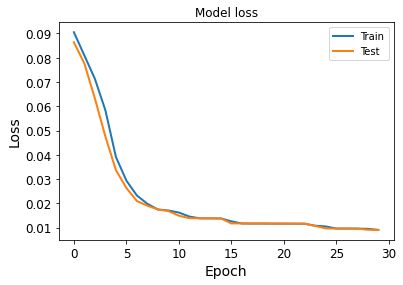

In [59]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [60]:
encoded = encoder_layer.predict(X_train)
ae_embeddings = pd.DataFrame(encoded)
print(ae_embeddings.shape)
ae_embeddings.head()

(22401, 18)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.015115,-0.265993,-0.074291,-0.113402,0.235578,-0.121776,-0.034155,-0.134798,0.144493,-0.072979,0.140795,-0.051716,0.173225,-0.143502,0.026818,0.060503,-0.021267,0.518435
1,0.046124,0.147627,-0.046186,-0.056037,-0.152196,-0.005792,-0.046820,-0.014795,-0.091185,0.116967,-0.006999,0.111100,-0.157619,-0.093190,0.027108,0.061939,-0.115741,0.615341
2,0.014389,0.119949,-0.072696,0.121235,-0.152814,0.028464,-0.033388,-0.206714,-0.033974,-0.110626,0.073497,-0.083012,-0.106496,0.017816,-0.020717,-0.049435,0.006264,0.718615
3,-0.186644,-0.319629,-0.043320,0.049632,0.179466,0.153439,0.154067,-0.015229,-0.088557,0.182747,-0.064273,-0.001989,0.011073,-0.308636,0.076304,-0.177686,0.248026,0.692275
4,-0.206158,-0.200039,-0.119192,0.146913,0.209992,0.028316,0.028600,0.005168,0.046593,0.127164,0.046357,0.091201,0.032440,-0.316876,0.050696,-0.031259,-0.010109,0.661145


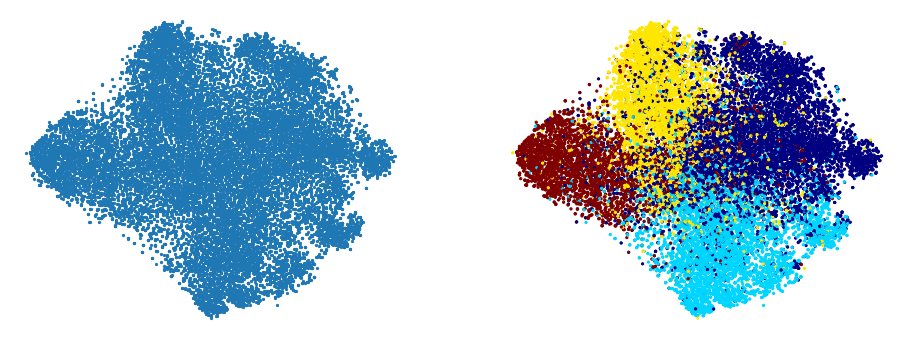

In [61]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=9)
X_train_tsne = tsne.fit_transform(ae_embeddings)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], s=5)
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, s=5, cmap="jet")
plt.axis("off")
plt.show()

=> The fig on the left is the shape/pattern of data after being compressed using PCA and T-SNE, and the fig on the right hand side is the underlying topic/class of the data

=> Assuming that we don't have label (hence the fig on the right hand side is not available), it can be seen on the left fig that the plot suggests there are around 4 clusters, 1 cluster at the top, and 2 clusters at middle, 1 cluster at the bottom

In [63]:
from sklearn.cluster import KMeans
from scipy import stats

def specify_num_of_clusters(data, n_clusters):
    wcss = []
    for i in range(1, n_clusters):
        kmeans = KMeans(n_clusters=i, random_state=0, init='k-means++')
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
        
    plt.plot(range(1,11), wcss)
    plt.title('Elbow Method')
    plt.xlabel("K Clusters")
    plt.ylabel("WCSS")
    plt.show()
    
    

def mapping_cluster_class(y, cluster):
    mapping = {}
    for class_id in np.unique(y):
        mode, _ = stats.mode(cluster[y==class_id])
        print(mode)
        mapping[mode[0]] = class_id
    return mapping

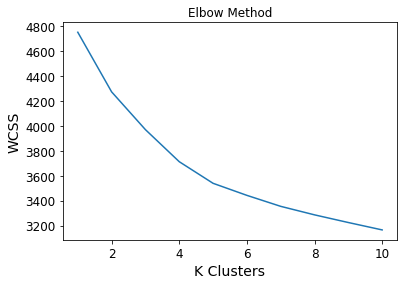

In [64]:
specify_num_of_clusters(ae_embeddings, 11)

In [65]:
ae_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.015115,-0.265993,-0.074291,-0.113402,0.235578,-0.121776,-0.034155,-0.134798,0.144493,-0.072979,0.140795,-0.051716,0.173225,-0.143502,0.026818,0.060503,-0.021267,0.518435
1,0.046124,0.147627,-0.046186,-0.056037,-0.152196,-0.005792,-0.046820,-0.014795,-0.091185,0.116967,-0.006999,0.111100,-0.157619,-0.093190,0.027108,0.061939,-0.115741,0.615341
2,0.014389,0.119949,-0.072696,0.121235,-0.152814,0.028464,-0.033388,-0.206714,-0.033974,-0.110626,0.073497,-0.083012,-0.106496,0.017816,-0.020717,-0.049435,0.006264,0.718615
3,-0.186644,-0.319629,-0.043320,0.049632,0.179466,0.153439,0.154067,-0.015229,-0.088557,0.182747,-0.064273,-0.001989,0.011073,-0.308636,0.076304,-0.177686,0.248026,0.692275
4,-0.206158,-0.200039,-0.119192,0.146913,0.209992,0.028316,0.028600,0.005168,0.046593,0.127164,0.046357,0.091201,0.032440,-0.316876,0.050696,-0.031259,-0.010109,0.661145


In [66]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=25)
kmeans.fit(ae_embeddings)
AE_Kmeans = kmeans.labels_
cluster_df = pd.DataFrame()
cluster_df['AE_Kmeans'] = AE_Kmeans
cluster_class = mapping_cluster_class(y_train, AE_Kmeans)
cluster_df['Cluster'] = cluster_df['AE_Kmeans'].map(cluster_class)

[1]
[3]
[0]
[2]


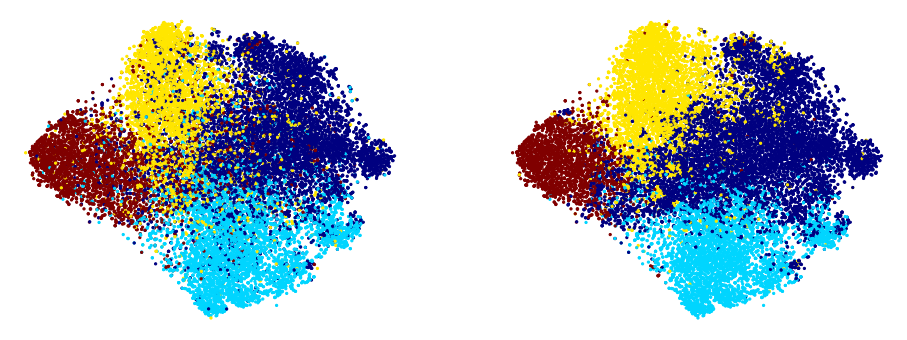

In [67]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, s=5, cmap="jet")
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=cluster_df['Cluster'], s=5, cmap="jet")
plt.axis("off")
plt.show()

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px"> 5. AE for ANOMALY DETECTION</div>

 # <font color=red>5.1. Data Preparation</font>

In [128]:
# read the data using pandas dataframe
df = pd.read_csv('data/Train_Titanic.csv')
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


 ### <font color=blue>**Target Variable**

In [129]:
Survived    = df[df['Survived']==1]
No_Survived = df[df['Survived']==0]

print("Total =", len(df))

print("Number of customers who Survived =", len(Survived))
print("Percentage bought =", 1.*len(Survived)/len(df)*100.0, "%")
 
print("Did not Survived =", len(No_Survived))
print("Percentage who did not Survived =", 1.*len(No_Survived)/len(df)*100.0, "%")

Total = 891
Number of customers who Survived = 342
Percentage bought = 38.38383838383838 %
Did not Survived = 549
Percentage who did not Survived = 61.61616161616161 %


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Survived Distribution \n (0: No Survived || 1: Survived)')

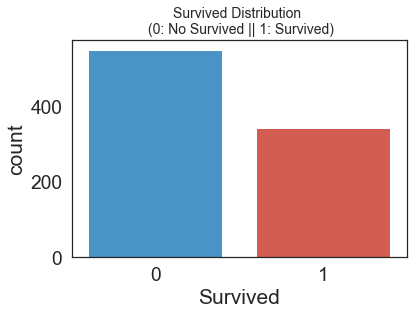

In [130]:
colors = ["#3498db","#e74c3c"]

sns.countplot('Survived', data=df,palette = colors)
plt.title('Survived Distribution \n (0: No Survived || 1: Survived)', fontsize = 14)

 ### <font color=blue>**Missing Data**

<Axes: >

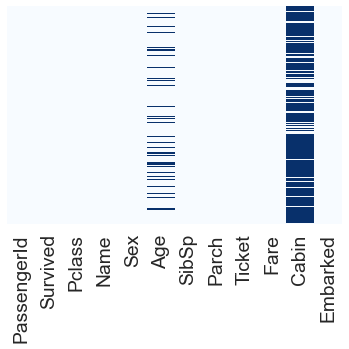

In [131]:
# Let's explore which dataset is missing
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

In [132]:
org_df = df
removed_features = ['Cabin','Name','Embarked','Ticket','PassengerId']
selected_featues = [e for e in df.columns if e not in removed_features]
selected_featues

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

In [133]:
df = org_df.loc[:,selected_featues]

<Axes: xlabel='Sex', ylabel='Age'>

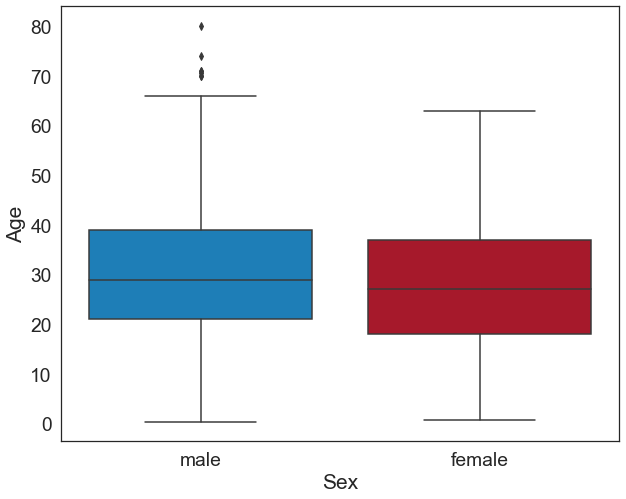

In [134]:
# Let's get the average age for male (~29) and female (~25)
plt.figure(figsize=(10, 8))
sns.boxplot(x='Sex', y='Age',data=df)

In [135]:
def Fill_Age(data):
    age = data[0]
    sex = data[1]

    if pd.isnull(age):
        if sex is 'male': 
            return 29
        else:
            return 25
    else:
        return age

<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-135-d4cc5d41c935>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if sex is 'male':


In [136]:
df['Age'] = df[['Age','Sex']].apply(Fill_Age,axis=1)

<Axes: >

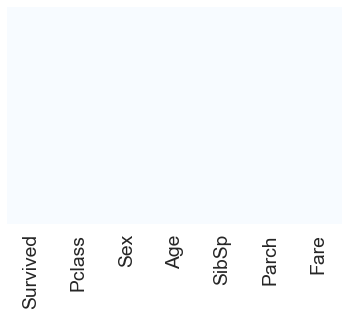

In [137]:
# Let's view the data one more time!
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

In [138]:
male = pd.get_dummies(df['Sex'], drop_first = True)
# first let's drop the embarked and sex 
df.drop(['Sex'], axis = 1, inplace = True)
# Now let's add the encoded column male again
df = pd.concat([df, male], axis=1)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male
0,0,3,22.0,1,0,7.2500,1
1,1,1,38.0,1,0,71.2833,0
2,1,3,26.0,0,0,7.9250,0
3,1,1,35.0,1,0,53.1000,0
4,0,3,35.0,0,0,8.0500,1


 ### <font color=blue> Split data into X and y

In [139]:
X = df.drop('Survived',axis=1)
y = df.Survived

 ### <font color=blue> Data Normalization

In [140]:
X_scaled.Age

0      0.271174
1      0.472229
2      0.321438
3      0.434531
4      0.434531
         ...   
886    0.334004
887    0.233476
888    0.308872
889    0.321438
890    0.396833
Name: Age, Length: 891, dtype: float64

In [141]:
from sklearn.preprocessing import  StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
X_scaled = X
X_scaled.Age = scaler.fit_transform(np.array(X_scaled.Age).reshape(-1,1))
X_scaled.Fare = scaler.fit_transform(np.array(X_scaled.Fare).reshape(-1,1))
X_scaled.Pclass = scaler.fit_transform(np.array(X_scaled.Pclass).reshape(-1,1))
X_scaled.head()

,Pclass,Age,SibSp,Parch,Fare,male
0,1.0,0.271174,1,0,0.014151,1
1,0.0,0.472229,1,0,0.139136,0
2,1.0,0.321438,0,0,0.015469,0
3,0.0,0.434531,1,0,0.103644,0
4,1.0,0.434531,0,0,0.015713,1


 ### <font color=blue> Split data into train-test split

In [142]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=10)

 # <font color=red>5.2. AutoEncoder</font>

In [143]:
####### Deep learning libraries
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
# from ann_visualizer.visualize import ann_viz
# 
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, roc_auc_score, auc,
                             precision_score, recall_score, roc_curve, precision_recall_curve,
                             precision_recall_fscore_support, f1_score,
                             precision_recall_fscore_support)
#
from IPython.display import display, Math, Latex
import datetime

In [144]:
#set up graphic style in this case I am using the color scheme from xkcd.com
LABELS = ["No Survived","Survived"]
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))

In [145]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male
0,0,3,22.0,1,0,7.2500,1
1,1,1,38.0,1,0,71.2833,0
2,1,3,26.0,0,0,7.9250,0
3,1,1,35.0,1,0,53.1000,0
4,0,3,35.0,0,0,8.0500,1


In [146]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state = 101)

X_train = X_train[X_train['Survived'] == 0]
X_train = X_train.drop(['Survived'], axis = 1)
y_test = X_test['Survived']
X_test = X_test.drop(['Survived'], axis = 1)
X_train = X_train.values
X_test = X_test.values
print('Training data size: ', X_train.shape)
print('Validation data size: ', X_test.shape)

Training data size:  (450, 6)
Validation data size:  (179, 6)


In [147]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [379]:
tf.random.set_seed(42)
np.random.seed(42)
keras.backend.clear_session()
tf.keras.backend.clear_session()

# No of Neurons in each Layer [6,5,2,5,6]
input_dim = X_train.shape[1]
encoding_dim = 4

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(5), activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(2), activation="tanh")(encoder)
#encoder = Dense(int(2), activation="tanh")(encoder)
#decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(5), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 5)                 35        
                                                                 
 dense_1 (Dense)             (None, 2)                 12        
                                                                 
 dense_2 (Dense)             (None, 5)                 15        
                                                                 
 dense_3 (Dense)             (None, 6)                 36        
                                                                 
Total params: 98
Trainable params: 98
Non-trainable params: 0
_________________________________________________________________


In [380]:
nb_epoch = 100
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

cp = ModelCheckpoint(filepath="autoencoder1.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

t_ini = datetime.datetime.now()


history = autoencoder.fit(X_train_scaled, X_train_scaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[cp, tb]).history

t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))



df_history = pd.DataFrame(history)

Epoch 1/100
9/9 [==============================] - 1s 25ms/step - loss: 0.2975 - val_loss: 0.2731
Epoch 2/100
9/9 [==============================] - 0s 13ms/step - loss: 0.2751 - val_loss: 0.2539
Epoch 3/100
9/9 [==============================] - 0s 12ms/step - loss: 0.2570 - val_loss: 0.2373
Epoch 4/100
9/9 [==============================] - 0s 12ms/step - loss: 0.2410 - val_loss: 0.2212
Epoch 5/100
9/9 [==============================] - 0s 12ms/step - loss: 0.2250 - val_loss: 0.2053
Epoch 6/100
9/9 [==============================] - 0s 11ms/step - loss: 0.2092 - val_loss: 0.1896
Epoch 7/100
9/9 [==============================] - 0s 14ms/step - loss: 0.1937 - val_loss: 0.1744
Epoch 8/100
9/9 [==============================] - 0s 16ms/step - loss: 0.1783 - val_loss: 0.1596
Epoch 9/100
9/9 [==============================] - 0s 16ms/step - loss: 0.1638 - val_loss: 0.1453
Epoch 10/100
9/9 [==============================] - 0s 12ms/step - loss: 0.1498 - val_loss: 0.1321
Epoch 11/100
9/9 [=

Epoch 84/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0349 - val_loss: 0.0440
Epoch 85/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0347 - val_loss: 0.0438
Epoch 86/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0345 - val_loss: 0.0436
Epoch 87/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0342 - val_loss: 0.0434
Epoch 88/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0340 - val_loss: 0.0431
Epoch 89/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0337 - val_loss: 0.0428
Epoch 90/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0334 - val_loss: 0.0423
Epoch 91/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0331 - val_loss: 0.0420
Epoch 92/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0328 - val_loss: 0.0417
Epoch 93/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0324 - val_loss: 0.0413
Epoch 94/10

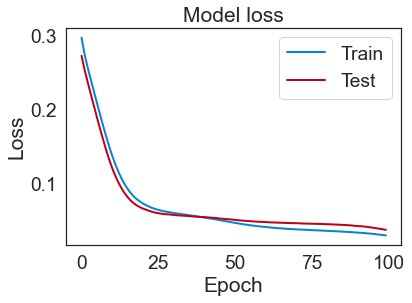

In [381]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [382]:
predictions = autoencoder.predict(X_test_scaled)

mse = np.mean(np.power(X_test_scaled - predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse, 'Label': y_test}, index=y_test.index)
df_error.describe()

,reconstruction_error,Label
count,179.000000,179.000000
mean,0.043190,0.446927
std,0.052135,0.498570
min,0.007020,0.000000
25%,0.010657,0.000000
50%,0.020322,0.000000
75%,0.070279,1.000000
max,0.523212,1.000000


In [383]:
df_error.head()

,reconstruction_error,Label
331,0.009761,0
700,0.138435,1
748,0.032790,0
751,0.020322,1
481,0.019538,0


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


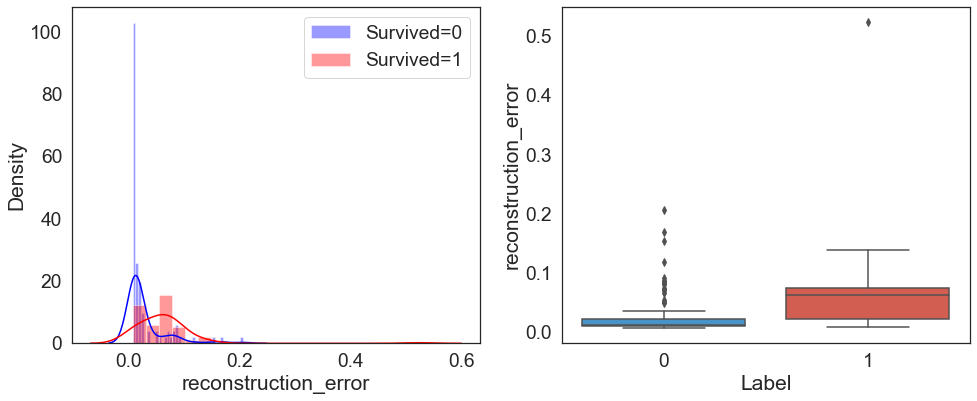

In [384]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 6))
sns.distplot(df_error.loc[df_error.Label==0,'reconstruction_error'],color='blue', ax=ax1, label='Survived=0')
sns.distplot(df_error.loc[df_error.Label==1,'reconstruction_error'],color='red', ax=ax1, label='Survived=1')
ax2 = sns.boxplot(x='Label', y='reconstruction_error', data=df_error, palette=colors)
ax1.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [385]:
# change X_tes_scaled to pandas dataframe
numerical_cols = ['V_1', 'V_2', 'V_3', 'V_4', 'V_5', 'V_6']
data_n = pd.DataFrame(X_test_scaled, index= y_test.index, columns = numerical_cols)
data_n.head()

,V_1,V_2,V_3,V_4,V_5,V_6
331,0.0,0.609589,0.000,0.000000,0.108365,1.0
700,0.0,0.232877,0.125,0.000000,0.865114,0.0
748,0.0,0.246575,0.125,0.000000,0.201901,1.0
751,1.0,0.068493,0.000,0.166667,0.047433,1.0
481,0.5,0.328767,0.000,0.000000,0.000000,1.0


In [386]:
reconstrcuted_df = autoencoder.predict(data_n)
reconstrcuted_df = pd.DataFrame(reconstrcuted_df, index= data_n.index.values)

In [387]:
reconstrcuted_df.columns = data_n.columns.values
reconstrcuted_df.head()

,V_1,V_2,V_3,V_4,V_5,V_6
331,0.020460,0.612298,-0.008720,0.013668,0.189413,0.773491
700,-0.508116,0.365955,-0.012783,-0.006916,0.280866,0.440838
748,0.156423,0.549759,0.004855,0.016966,0.175967,0.745135
751,0.891488,0.278083,0.098844,0.066280,0.042038,0.784697
481,0.707460,0.484453,0.050783,0.052397,0.100072,0.813964


In [388]:
RE_per_dim_df = abs(data_n - reconstrcuted_df)
RE_per_dim_df.head()

,V_1,V_2,V_3,V_4,V_5,V_6
331,0.020460,0.002709,0.008720,0.013668,0.081048,0.226509
700,0.508116,0.133078,0.137783,0.006916,0.584248,0.440838
748,0.156423,0.303184,0.120145,0.016966,0.025935,0.254865
751,0.108512,0.209590,0.098844,0.100387,0.005395,0.215303
481,0.207460,0.155686,0.050783,0.052397,0.100072,0.186036


In [389]:
RE_per_dim_df['Survived'] = y_test
RE_per_dim_df['reconstruction_error'] = df_error['reconstruction_error']
RE_per_dim_df.head(10)

,V_1,V_2,V_3,V_4,V_5,V_6,Survived,reconstruction_error
331,0.020460,0.002709,0.008720,0.013668,0.081048,0.226509,0,0.009761
700,0.508116,0.133078,0.137783,0.006916,0.584248,0.440838,1,0.138435
748,0.156423,0.303184,0.120145,0.016966,0.025935,0.254865,0,0.032790
751,0.108512,0.209590,0.098844,0.100387,0.005395,0.215303,1,0.020322
481,0.207460,0.155686,0.050783,0.052397,0.100072,0.186036,0,0.019538
845,0.141036,0.108728,0.075107,0.078584,0.033761,0.148732,0,0.011132
740,0.110204,0.249821,0.001057,0.016408,0.066068,0.241028,1,0.022881
287,0.111924,0.058518,0.092844,0.072750,0.017578,0.179368,0,0.010391
669,0.354631,0.008125,0.124766,0.004247,0.055855,0.421634,1,0.053718
241,0.183231,0.248209,0.024285,0.038188,0.004979,0.572346,1,0.070806


### ROC Curve Check

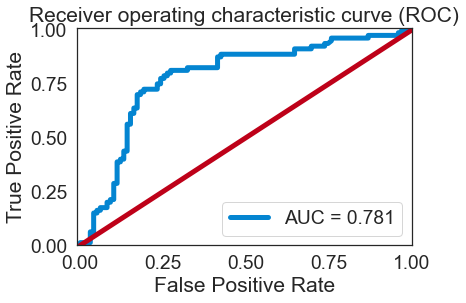

In [390]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(df_error.Label, df_error.reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [391]:
roc_auc

0.7808712121212121

In [392]:
ROC_df = pd.DataFrame()
ROC_df['false_pos_rate'] = false_pos_rate
ROC_df['true_pos_rate'] = true_pos_rate
ROC_df['thresholds'] = thresholds
ROC_df.head(25)

,false_pos_rate,true_pos_rate,thresholds
0,0.000000,0.0000,1.523212
1,0.000000,0.0125,0.523212
2,0.030303,0.0125,0.153944
3,0.030303,0.0625,0.133067
4,0.040404,0.0625,0.119297
5,0.040404,0.1500,0.091916
6,0.050505,0.1500,0.091355
7,0.050505,0.1625,0.087846
8,0.060606,0.1625,0.087148
9,0.060606,0.1750,0.087000


### Recall vs. Precision Thresholding

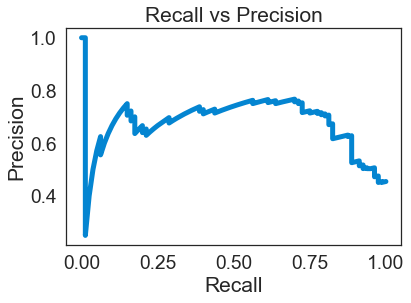

In [393]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(df_error.Label, df_error.reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [394]:
PR_df = pd.DataFrame()
PR_df['precision_rt'] = precision_rt[1:len(threshold_rt)]
PR_df['recall_rt'] = recall_rt[1:len(threshold_rt)]
PR_df['threshold_rt'] = threshold_rt[1:len(threshold_rt)]
PR_df.head(20)

,precision_rt,recall_rt,threshold_rt
0,0.451429,0.9875,0.008389
1,0.454023,0.9875,0.008616
2,0.450867,0.9750,0.008869
3,0.453488,0.9750,0.008945
4,0.456140,0.9750,0.009238
5,0.458824,0.9750,0.009251
6,0.461538,0.9750,0.009263
7,0.464286,0.9750,0.009277
8,0.467066,0.9750,0.009301
9,0.469880,0.9750,0.009350


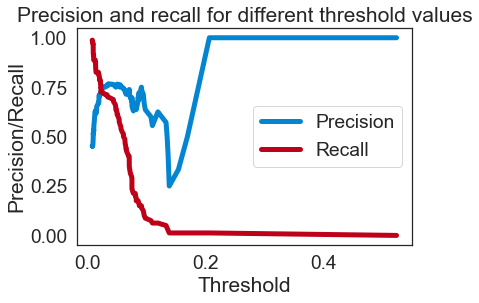

In [395]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

### Reconstruction Error vs Threshold Check

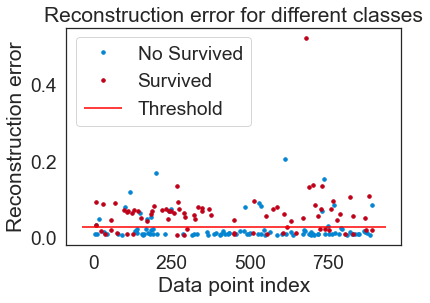

In [396]:
threshold_fixed = 0.03
groups = df_error.groupby('Label')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Survived" if name == 1 else "No Survived")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

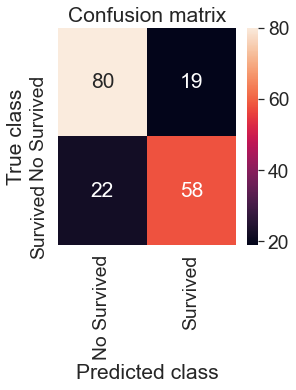

In [397]:
pred_y = [1 if e > threshold_fixed else 0 for e in df_error.reconstruction_error.values]
conf_matrix = confusion_matrix(df_error.Label, pred_y)

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [398]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80        99
           1       0.75      0.72      0.74        80

    accuracy                           0.77       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.77      0.77      0.77       179

